In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [2]:
batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10

beta= 1.

save_folder = 'pretraining-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

In [4]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

In [158]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

        self.pre1_mu_layer = nn.Linear(en_hidden1_dim,latent_dim)##2000 => 10 for MNIST
        self.pre1_std_layer = nn.Linear(en_hidden1_dim,latent_dim)##2000 => 10 for MNIST
        self.pre1_decode3_layer = nn.Linear(latent_dim,de_hidden3_dim)##10 => 2000 for MNIST

        self.pre2_mu_layer = nn.Linear(en_hidden2_dim,latent_dim)##2000 => 10 for MNIST
        self.pre2_std_layer = nn.Linear(en_hidden2_dim,latent_dim)##2000 => 10 for MNIST
        self.pre2_decode2_layer = nn.Linear(latent_dim,de_hidden2_dim)##10 => 2000 for MNIST

        self.pre3_mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.pre3_std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.pre3_decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST


    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている

    def pre1_encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        return self.pre1_mu_layer(en_h1), self.pre1_std_layer(en_h1)

    def pre2_encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        return self.pre2_mu_layer(en_h2), self.pre2_std_layer(en_h2)

    def pre3_encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.pre3_mu_layer(en_h3), self.pre3_std_layer(en_h3)


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている

    def pre1_decode(self,z):
        de_h3 = F.relu(self.pre1_decode3_layer(z))
        return torch.sigmoid(self.output_layer(de_h3))

    def pre2_decode(self,z):
        de_h2 = F.relu(self.pre2_decode2_layer(z))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))

    def pre3_decode(self,z):
        de_h1 = F.relu(self.pre3_decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている

    def pre1_forward(self, x):
        mu, logvar = self.pre1_encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.pre1_decode(z),mu,logvar,z

    def pre2_forward(self, x):
        mu, logvar = self.pre2_encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.pre2_decode(z),mu,logvar,z

    def pre3_forward(self, x):
        mu, logvar = self.pre3_encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.pre3_decode(z),mu,logvar,z

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.9)

pre1_params = list(model.input_layer.parameters())+list(model.output_layer.parameters())+list(model.pre1_mu_layer.parameters())+list(model.pre1_std_layer.parameters())+list(model.pre1_decode3_layer.parameters())
pre1_optimizer = optim.Adam(pre1_params,lr=0.002)

pre2_params = list(model.encode1_layer.parameters())+list(model.decode3_layer.parameters())+list(model.pre2_mu_layer.parameters())+list(model.pre2_std_layer.parameters())+list(model.pre2_decode2_layer.parameters())
pre2_optimizer = optim.Adam(pre2_params,lr=0.002)

pre3_params = list(model.encode2_layer.parameters())+list(model.decode2_layer.parameters())+list(model.pre3_mu_layer.parameters())+list(model.pre3_std_layer.parameters())+list(model.pre3_decode1_layer.parameters())
pre3_optimizer = optim.Adam(pre3_params,lr=0.002)


In [113]:
def loss_function(recon_x,x,mu,logvar):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())

    return BCE+beta*KLD



In [114]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [115]:
def pre1_train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        pre1_optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model.pre1_forward(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        pre1_optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [116]:
def pre1_train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        pre1_optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model.pre1_forward(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        pre1_optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [117]:
def pre2_train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        pre2_optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model.pre2_forward(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        pre2_optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [118]:
def pre3_train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        pre3_optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model.pre3_forward(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function(recon_batch,data,mu,logvar)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        pre3_optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [119]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [120]:
def pre1_test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model.pre1_forward(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_pre1_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [121]:
def pre2_test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model.pre2_forward(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_pre2_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [122]:
def pre3_test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model.pre3_forward(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function(recon_batch,data,mu,logvar).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_pre3_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))


In [123]:
def initial_train(epochs):
    for epoch in range(1, epochs +1):
        train(epoch)
        test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [124]:
def pre1_loop(epochs):
    for epoch in range(1, epochs +1):
        pre1_train(epoch)
        pre1_test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.pre1_decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_pre1_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [125]:
def pre2_loop(epochs):
    for epoch in range(1, epochs +1):
        pre2_train(epoch)
        pre2_test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.pre2_decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_pre2_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [126]:
def pre3_loop(epochs):
    for epoch in range(1, epochs +1):
        pre3_train(epoch)
        pre3_test(epoch)
        scheduler.step()
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.pre3_decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_pre3_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [127]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    return zs,ts,mus,logvars

In [128]:
def pre1_take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)

    for batch_idx, (x,t) in enumerate(test_loader):

        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model.pre1_forward(x)
            t = t.to(device)

            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)

    return zs,ts,mus,logvars

In [129]:
def pre2_take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)

    for batch_idx, (x,t) in enumerate(test_loader):

        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model.pre2_forward(x)
            t = t.to(device)

            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)

    return zs,ts,mus,logvars

In [130]:
def pre3_take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)

    for batch_idx, (x,t) in enumerate(test_loader):

        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model.pre3_forward(x)
            t = t.to(device)

            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)

    return zs,ts,mus,logvars

In [131]:
def initialize_centers():

    #mu_center = mus.mean(0,keepdim=True).detach().requires_grad_(False)
    #mus_white = mus.detach().requires_grad_(False)-mu_center
    #cov_mus = torch.matmul(mus_white.squeeze(2).t(),mus_white.squeeze(2))/mus.shape[0]

    #mu_distribution = MultivariateNormal(loc=mu_center.view(-1,latent_dim),covariance_matrix=cov_mus)
    #mu_c = mu_distribution.sample([K_model_cluster,])
    #mu_c = mu_c.permute(1,2,0)

    #logvar_c = torch.diag(cov_mus).log()
    #logvar_c = logvar_c.view(1,latent_dim,1)
    #logvar_c = logvar_c.repeat(1,1,K_model_cluster)

    #mu_distribution = MultivariateNormal(loc=torch.zeros(latent_dim),covariance_matrix=torch.eye(latent_dim))
    #mu_c = mu_distribution.sample([K_model_cluster,])
    #mu_c = mu_c.permute(1,0)
    #mu_c = mu_c.view(1,latent_dim,K_model_cluster).to(device)


    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)

    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device).requires_grad_(False)

    pi_c = torch.full((1,1,K_model_cluster),1./K_model_cluster).to(device).requires_grad_(False)

    return mu_c,logvar_c,pi_c

In [132]:
def gauss(mus,logvars,mu_c,logvar_c,pi_c,iter):
    #mus = mus_ini
    #logvars = logvars_ini
    #mu_c = mu_c_ini
    #logvar_c = logvar_c_ini
    #pi_c = pi_c_ini

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/(pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True)

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((pi_c*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/(Q_c.shape)[0]
            pi_c= N_c/N_c.sum()
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P

In [133]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

In [134]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [135]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,pi_c_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    #recon_xはsigmoidをdecordeで通されているので、[0,1]になっている。
    #KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    #Q_c_f = -logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())
    #KLD = (((pi_c_f*((-0.5*(-logvars_f+logvar_c_f+logvars_f.exp()/(logvar_c_f.exp())+(mus_f-mu_c_f).pow(2)/(logvar_c_f.exp())).sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()
    KLD = -0.5*(1+logvars_f).sum() -(((pi_c_f*(-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/logvar_c_f.exp()).sum(1,keepdim=True))).exp()).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [136]:
def train_c(epoch,mu_c,logvar_c,pi_c):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る
        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,pi_c_f=pi_c)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #パラメータの更新
        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [137]:
def test_c(epoch,mu_c,logvar_c,pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,pi_c_f=pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [138]:
def train_c_epoch(epochs,mu_c,logvar_c,pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,pi_c)
        test_c(epoch,mu_c,logvar_c,pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [159]:
beta = 0.

In [160]:
pre1_loop(10)
zs_g,ts_g,mus_g,logvars_g = pre1_take_latents()

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.779375
====> Test set loss: 0.9442
Train Epoch: 2 [0/60000 (0%)]	Loss: 90.795645
====> Test set loss: 0.8588
Train Epoch: 3 [0/60000 (0%)]	Loss: 91.435986
====> Test set loss: 0.8674
Train Epoch: 4 [0/60000 (0%)]	Loss: 84.735391
====> Test set loss: 0.7838
Train Epoch: 5 [0/60000 (0%)]	Loss: 84.949980
====> Test set loss: 0.8531
Train Epoch: 6 [0/60000 (0%)]	Loss: 85.920625
====> Test set loss: 0.8457
Train Epoch: 7 [0/60000 (0%)]	Loss: 81.998818
====> Test set loss: 0.8462
Train Epoch: 8 [0/60000 (0%)]	Loss: 79.660918
====> Test set loss: 0.7763
Train Epoch: 9 [0/60000 (0%)]	Loss: 83.345811
====> Test set loss: 0.7814
Train Epoch: 10 [0/60000 (0%)]	Loss: 81.136968
====> Test set loss: 0.8197


In [164]:
pre2_loop(10)
zs_g,ts_g,mus_g,logvars_g = pre2_take_latents()

Train Epoch: 1 [0/60000 (0%)]	Loss: 248.098027
====> Test set loss: 0.9051
Train Epoch: 2 [0/60000 (0%)]	Loss: 91.631230
====> Test set loss: 0.8265
Train Epoch: 3 [0/60000 (0%)]	Loss: 81.738691
====> Test set loss: 0.8406
Train Epoch: 4 [0/60000 (0%)]	Loss: 86.441797
====> Test set loss: 0.8308
Train Epoch: 5 [0/60000 (0%)]	Loss: 88.819531
====> Test set loss: 0.8643
Train Epoch: 6 [0/60000 (0%)]	Loss: 86.160469
====> Test set loss: 0.8224
Train Epoch: 7 [0/60000 (0%)]	Loss: 83.045898
====> Test set loss: 0.8003
Train Epoch: 8 [0/60000 (0%)]	Loss: 79.453413
====> Test set loss: 0.8198
Train Epoch: 9 [0/60000 (0%)]	Loss: 81.642900
====> Test set loss: 0.8093
Train Epoch: 10 [0/60000 (0%)]	Loss: 77.545610
====> Test set loss: 0.8571


In [168]:
pre3_loop(10)
zs_g,ts_g,mus_g,logvars_g = pre2_take_latents()

Train Epoch: 1 [0/60000 (0%)]	Loss: 282.320391
====> Test set loss: 0.9476
Train Epoch: 2 [0/60000 (0%)]	Loss: 98.796553
====> Test set loss: 0.9371
Train Epoch: 3 [0/60000 (0%)]	Loss: 96.180898
====> Test set loss: 0.9262
Train Epoch: 4 [0/60000 (0%)]	Loss: 92.892715
====> Test set loss: 0.8750
Train Epoch: 5 [0/60000 (0%)]	Loss: 93.687383
====> Test set loss: 0.9059
Train Epoch: 6 [0/60000 (0%)]	Loss: 94.510352
====> Test set loss: 0.8808
Train Epoch: 7 [0/60000 (0%)]	Loss: 92.793535
====> Test set loss: 0.9040
Train Epoch: 8 [0/60000 (0%)]	Loss: 95.714199
====> Test set loss: 0.8929
Train Epoch: 9 [0/60000 (0%)]	Loss: 86.945449
====> Test set loss: 0.8597
Train Epoch: 10 [0/60000 (0%)]	Loss: 86.791191
====> Test set loss: 0.8574


In [172]:
#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,pi_c_g = initialize_centers()
mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [173]:
for i in range(50):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)
    scheduler.step()
    zs_g,ts_g,mus_g,logvars_g = take_latents()


    mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)



#(lo
# gvars_g.exp()).mean(0,keepdim=True).shape
#logvar_c_g.exp().shape
#(logvars_g.exp()/logvar_c_g.exp())[0,:,0]
#(-0.5*Q_c_g.sum(1,keepdim=True)).exp()
#(((mus_g-mu_c_g).pow(2))/(logvar_c_g.exp())).mean(0,keepdim=True),(logvars_g.exp()).mean(0,keepdim=True)
#logvar_c_g.exp()+(logvars_g.exp()).mean(0,keepdim=True)
log_P_g,pi_c_g

Train Epoch: 0 [0/60000 (0%)]	Loss: 408.239531
====> Test set loss: 0.8565
Train Epoch: 1 [0/60000 (0%)]	Loss: 88.874580
====> Test set loss: 0.7899
Train Epoch: 2 [0/60000 (0%)]	Loss: nan


RuntimeError: reduce failed to synchronize: device-side assert triggered

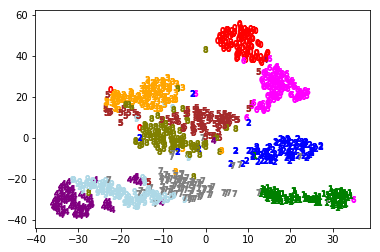

In [169]:
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,ts_g.cpu().detach().numpy())

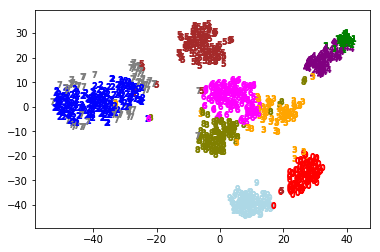

In [157]:
drawpoints(points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())

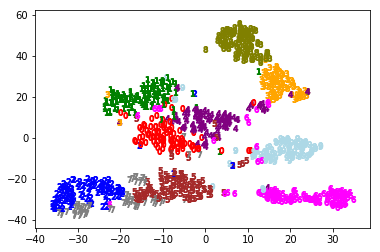

In [170]:
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,kmeans_model.labels_)

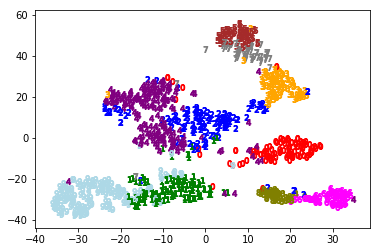

In [171]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))

In [ ]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [120]:
optimizer.param_groups[0]['lr']

8.478231655043248e-05

In [181]:

mu_c_g = torch.from_numpy(kmeans_model.cluster_centers_).to(device)

In [184]:
mu_c_g = mu_c_g.view(1,latent_dim,K_model_cluster)

In [186]:
mu_c_g.shape

torch.Size([1, 10, 10])